In [1]:
import os
from dataclasses import dataclass
from pathlib import Path

import bpy
import mathutils
from mathutils import Vector

In [2]:
# create empty scene
bpy.ops.wm.read_factory_settings(use_empty=True)

{'FINISHED'}

In [3]:
# load obj file
obj_filepath = "data/model.obj"
bpy.ops.wm.obj_import(filepath=obj_filepath)

OBJ import of 'model.obj' took 10.22 ms


{'FINISHED'}

In [4]:
objects = [obj for obj in bpy.data.objects if obj.type == "MESH"]
print(objects)

[bpy.data.objects['model']]


In [5]:
def scale_to_unit_cube(obj):
    # Get the object's bounding box corners in world space
    bbox_corners = [obj.matrix_world @ Vector(corner) for corner in obj.bound_box]
    
    # Calculate the bounding box dimensions
    min_x = min(corner.x for corner in bbox_corners)
    max_x = max(corner.x for corner in bbox_corners)
    min_y = min(corner.y for corner in bbox_corners)
    max_y = max(corner.y for corner in bbox_corners)
    min_z = min(corner.z for corner in bbox_corners)
    max_z = max(corner.z for corner in bbox_corners)
    
    width = max_x - min_x
    height = max_y - min_y
    depth = max_z - min_z
    
    # Calculate scale factors to make the object a unit cube
    scale_x = 1.0 / width if width != 0 else 1.0
    scale_y = 1.0 / height if height != 0 else 1.0
    scale_z = 1.0 / depth if depth != 0 else 1.0
    
    # Use the smallest scale factor to maintain proportions
    # Or use individual scale factors for a true unit cube
    scale_factor = min(scale_x, scale_y, scale_z)  # For proportional scaling
    # OR
    # scale_vector = (scale_x, scale_y, scale_z)  # For non-proportional scaling
    
    # Apply scaling to the object
    obj.scale *= scale_factor  # For proportional scaling
    # OR 
    # obj.scale = obj.scale.x * scale_x, obj.scale.y * scale_y, obj.scale.z * scale_z
    
    # Apply scale
    bpy.ops.object.transform_apply(location=False, rotation=False, scale=True)
    
    # Optional: Center the object at origin
    obj.location = (0, 0, 0)


def move_object_to_center(obj):
    bbox_corners = [obj.matrix_world @ Vector(corner) for corner in obj.bound_box]
    bbox_center = sum((Vector(corner) for corner in bbox_corners), Vector()) / 8
    translation_vector = -bbox_center
    obj.location += translation_vector

assert len(objects) == 1
object = objects[0]
scale_to_unit_cube(object)
move_object_to_center(object)

# Setup a Simple Scene

### Setup a camera

In [6]:
# add a camera
@dataclass
class CameraConfig:
    x: float
    y: float
    z: float
    look_at: tuple[float, float, float]

camera_config = CameraConfig(
    x=0,
    y=3,
    z=1,
    look_at=(0, 0, 0),
)

bpy.ops.object.camera_add(
    location=(
        camera_config.x,
        camera_config.y,
        camera_config.z,
    ),
)

# camera_object = bpy.context.object
# look_at = mathutils.Vector(camera_config.look_at)
# direction = look_at - camera_object.location

# # Convert direction to rotation
# # The camera points along negative Z, so we use that as the "forward" direction
# rot_quat = direction.to_track_quat('-Z', 'Y')
# camera_object.rotation_euler = rot_quat.to_euler()


{'FINISHED'}

In [7]:
bpy.context.scene.camera = bpy.data.objects["Camera"]

In [8]:
# create a target where the camera tracks
camera = bpy.data.objects["Camera"]
bpy.ops.object.empty_add( location=(0, 0, 0) )
target = bpy.data.objects["Empty"]
camera_tracker = camera.constraints.new(type='TRACK_TO')
camera_tracker.target = target
camera_tracker.track_axis = 'TRACK_NEGATIVE_Z'
camera_tracker.up_axis = 'UP_Y'

### Add sunlight 

In [9]:
# Create a sun light
light_data = bpy.data.lights.new(name="Sun", type="SUN")
light_object = bpy.data.objects.new(name="Sun", object_data=light_data)

# Link the light to the scene
bpy.context.collection.objects.link(light_object)
light_data.energy = 5.0  # Strength

### Light up 6 directions

In [10]:
import math

# Parameters for hexagon layout
num_lights = 6  # Hexagon has 6 sides
radius = 3.0  # Distance from center
height = 3.0  # Height above ground
light_size = 2.0  # Size of each area light
light_energy = 70.0  # Brightness of lights
light_color = (1.0, 0.9, 0.8)  # Slightly warm white


for i in range(num_lights):
    # Calculate angle in radians (distribute evenly in a circle)
    angle = 2.0 * math.pi * i / num_lights
    
    # Calculate position based on angle and radius
    x = radius * math.cos(angle)
    y = radius * math.sin(angle)
    
    # Add area light
    bpy.ops.object.light_add(type='AREA', location=(x, y, height))
    
    # Get the created light object
    light_obj = bpy.context.active_object
    
    # Configure light properties
    light_obj.data.shape = 'RECTANGLE'
    light_obj.data.size = light_size
    light_obj.data.size_y = light_size
    light_obj.data.energy = light_energy
    light_obj.data.color = light_color

    light_tracker = light_obj.constraints.new(type='TRACK_TO')
    light_tracker.target = target
    light_tracker.track_axis = 'TRACK_NEGATIVE_Z'
    light_tracker.up_axis = 'UP_Y'
    # direction = Vector((0,0,0)) - Vector((x, y, height))
    # direction.normalize()

    # light_obj.rotation_euler = direction.to_track_quat('-Z', 'Y').to_euler()


### Renderer

In [11]:
@dataclass
class RenderConfig:
    resolution_x: int
    resolution_y: int
    output_path: Path

render_config = RenderConfig(
    resolution_x=1080,
    resolution_y=1080,
    output_path=Path("output") / "render.png",
)

scene = bpy.context.scene
render = scene.render
render.resolution_x = render_config.resolution_x
render.resolution_y = render_config.resolution_y
# Configure output settings
scene.render.image_settings.file_format = "PNG"
scene.render.image_settings.color_mode = "RGBA"
scene.render.film_transparent = True  # Transparent background option
scene.render.filepath = str(render_config.output_path.absolute())

bpy.ops.render.render(animation=False, write_still=True)

Fra:1 Mem:62.49M (Peak 64.19M) | Time:00:00.29 | Rendering 1 / 64 samples
Fra:1 Mem:62.49M (Peak 64.19M) | Time:00:00.33 | Rendering 25 / 64 samples
Fra:1 Mem:62.49M (Peak 64.19M) | Time:00:00.37 | Rendering 50 / 64 samples
Fra:1 Mem:62.49M (Peak 64.19M) | Time:00:00.39 | Rendering 64 / 64 samples
Saved: '/home/liu/Workspace/project-mvrdv/model_viewer/output/render.png'
Time: 00:00.55 (Saving: 00:00.13)



{'FINISHED'}

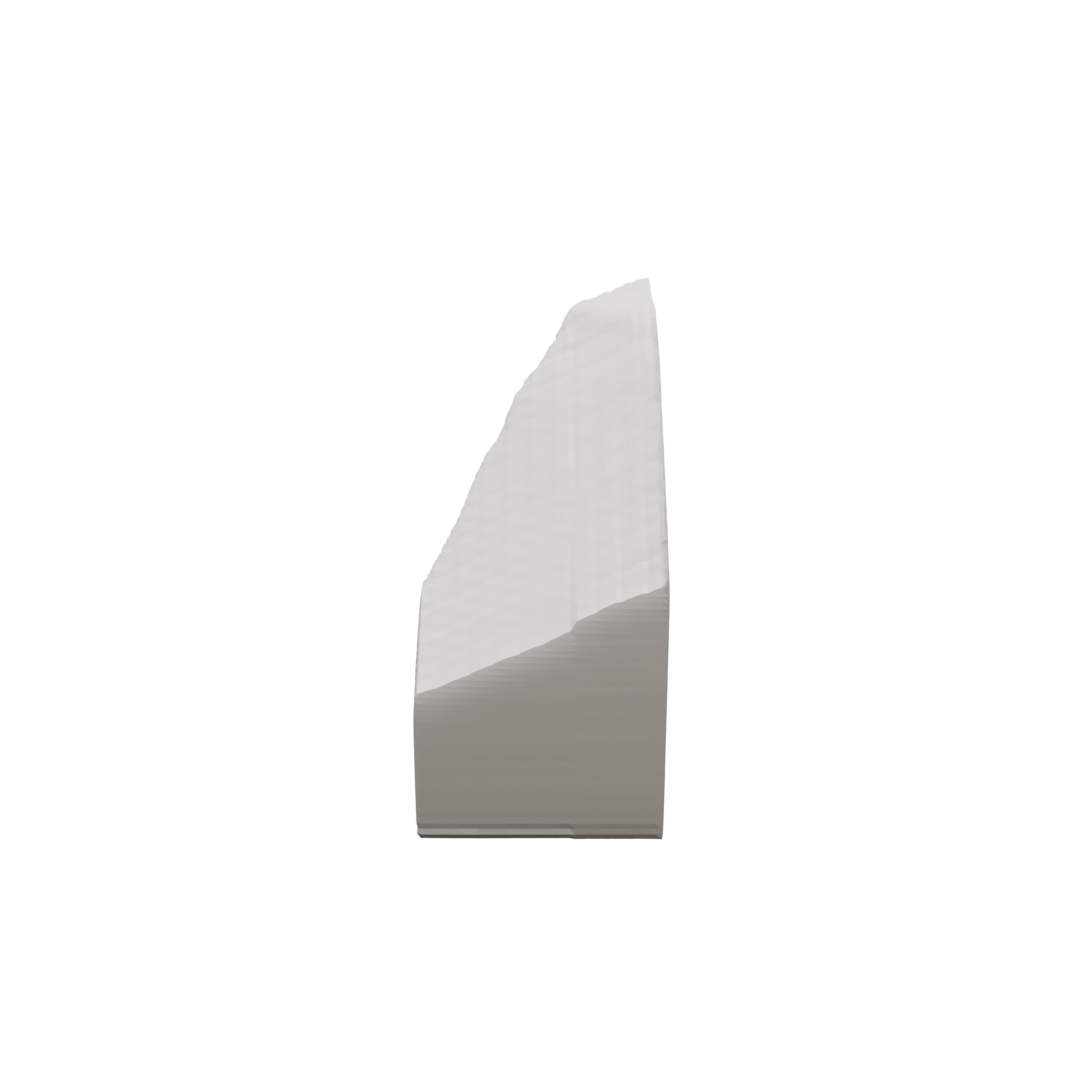

In [12]:
from IPython import display

display.Image(render_config.output_path)

# Save to Blend 

In [ ]:
# save it to blend file 
output_dir = Path("output")
output_dir.mkdir(parents=True, exist_ok=True)
blend_filepath = Path(output_dir) / "model.blend"

bpy.ops.wm.save_mainfile(
    filepath=str(blend_filepath.absolute()),  # bpy requires full path
    relative_remap=False,  # update assets links
    exit=True  # whether exit Blender after saving
)